# Key Takeaways

Chapter 2 of Eryk Lewinson's [*Python for Finance Cookbook*](https://www.packtpub.com/product/python-for-finance-cookbook/9781789618518) discusses a handful of trading strategies based on technical analysis.

***The key takeaways from this notebook are:***

1. Implementing and evaluating a trading strategy based on past prices and returns

***Note:*** Indented block quotes are from Lewinson, and section numbers differ from Lewinson because we will not discuss every topic.

I love the topics in Lewinson.
However, I will simplify and streamline his code, where possible.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
plt.rcParams['figure.dpi'] = 150
np.set_printoptions(precision=4, suppress=True)
pd.options.display.float_format = '{:.4f}'.format

In [3]:
import yfinance as yf
import requests_cache
session = requests_cache.CachedSession(expire_after='1D')

# Backtesting a Strategy Based on Simple Moving Average

Lewinson uses the backtrader package to implement his technical trading strategies.
However, there are not recent code commits to [backtrader's GitHub repository](https://github.com/mementum/backtrader), so it may be abandoned.
This is not a problem, because we can manually implement these stategies and learn a lot in the process!

The first strategy is a simple moving average (SMA) stategy that:

> For this recipe, we consider a basic strategy based on the SMA. The key points of the strategy are as follows:
>
>   - When the close price becomes higher than the 20-day SMA, buy one share.
>   - When the close price becomes lower than the 20-day SMA and we have a share, sell it.
>   - We can only have a maximum of one share at any given time.
>   - No short selling is allowed.

We do these calculations in *dollar* terms instead of *share* terms.

First we download data.

In [4]:
aapl = yf.download('AAPL', session=session)

[*********************100%***********************]  1 of 1 completed


Second, we calculate daily returns and add SMA(20) for the adjusted close.
We use the adjust close because we do not want to misinterpret splits and dividends as price changes.

In [5]:
aapl['R_AAPL'] = aapl['Adj Close'].pct_change()
aapl['SMA20'] = aapl['Adj Close'].rolling(20).mean()

Third, we add a `Position` column based on AAPL's adjusted close and SMA(20) columns.
`Position` takes one of two values: `1` if we are long AAPL and `0` if we are neutral AAPL.
`np.select()` avoids nested `np.where()` and accepts a default.
We `.shift()` inputs one day because we do not know closing prices and SMA(20) until the end of the day.
Therefore, we cannot update `Position` until the next trading day.

In [6]:
aapl['Position'] = np.select(
    condlist=[
        aapl['Adj Close'].shift() > aapl['SMA20'].shift(), # .shift() to use lagged values to prevent look-ahead bias
        aapl['Adj Close'].shift() <= aapl['SMA20'].shift()
    ], 
    choicelist=[1, 0],
    default=np.nan
)

In [7]:
aapl['Position'].fillna(value=0, inplace=True) # we start SMA(20) strategy with neutral position (but starting long is reasonable, too)

I find the following two tricks helpful:

First, plot the adjusted close, SMA(20), and position:

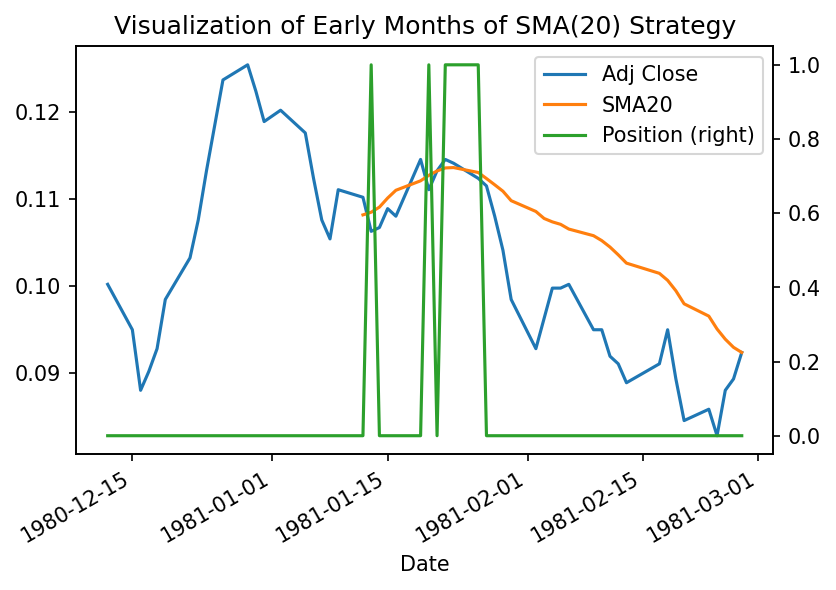

In [8]:
aapl.loc[:'1981-02', ['Adj Close', 'SMA20', 'Position']].plot(secondary_y='Position')
plt.title('Visualization of Early Months of SMA(20) Strategy')
plt.show()

Second, copy-and-paste these data to Excel!

In [9]:
# aapl.to_clipboard()

Finally, we create a `R_Strategy` column that provides the return on the strategy.
We will assume that we earn a cash return of 0% when we are neutral AAPL.

In [10]:
# aapl['R_Strategy'] = aapl['Position'] * aapl['R_AAPL'] # receive AAPL's return when long (position = 1), otherwise receive cash return of 0
aapl.eval('R_Strategy = Position * R_AAPL', inplace=True) # .eval() is often more compact and readable

We can plot the cumulative return on 1 dollar invested in this SMA(20) strategy.
We drop missing values to make an apples-to-apples comparison between the buy-and-hold and SMA(20) strategies.
There are missing values for both strategies because:

1. We need 2 days to calculate 1 daily return 
1. We need 20 days to calculate the first SMA(20)

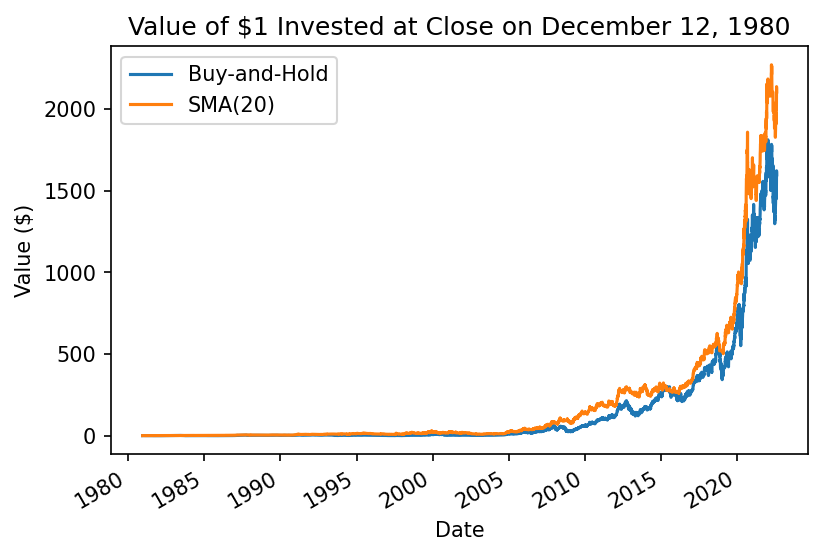

In [11]:
_ = aapl[['R_AAPL', 'R_Strategy']].dropna().add(1).cumprod()
buy_date = (_.index[0] - pd.offsets.BDay()).strftime('%B %d, %Y')
_.plot()
plt.ylabel('Value ($)')
plt.legend(['Buy-and-Hold', 'SMA(20)'])
plt.title('Value of $1 Invested at Close on ' + buy_date)
plt.show()

---

***Practice:***
What at the dollar values of these two investments at the end of the sample?

There are two solutions:

First, we can grab the last row from the cumulative value plot above:

In [12]:
_.tail(1)

,R_AAPL,R_Strategy
Date,,
2022-08-02,1597.2496,2104.5065


In [13]:
_.iloc[-1]

R_AAPL       1597.2496
R_Strategy   2104.5065
Name: 2022-08-02 00:00:00, dtype: float64

Second, we can use `.prod()` to compound all rows.

In [14]:
aapl[['R_AAPL', 'R_Strategy']].dropna().add(1).prod() 

R_AAPL       1597.2496
R_Strategy   2104.5065
dtype: float64

***Practice:***
What is the cumulative return (in %) of these two strategies in 2019?

In [15]:
aapl.loc['2019', ['R_AAPL', 'R_Strategy']].add(1).prod().sub(1) * 100

R_AAPL       88.9578
R_Strategy   74.6235
dtype: float64

The `.add(1).prod().sub(1)` code is fast.
However, if speed is not critical, we can improve readability with a total return function.

In [16]:
def totret(x):
    return (1 + x).prod() - 1

In [17]:
aapl.loc['2019', ['R_AAPL', 'R_Strategy']].apply(totret) * 100

R_AAPL       88.9578
R_Strategy   74.6235
dtype: float64

***Practice:***
Plot the cumulative return (in %) of these two strategies each year.

***WE WILL START HERE ON TUESDAY!***

In [18]:
list_aapl = []
list_strategy = []
for y in range(1980, 2023):
    list_aapl.append(aapl.loc[str(y), ['R_AAPL']].apply(totret)[0])
    list_strategy.append(aapl.loc[str(y), ['R_Strategy']].apply(totret)[0])

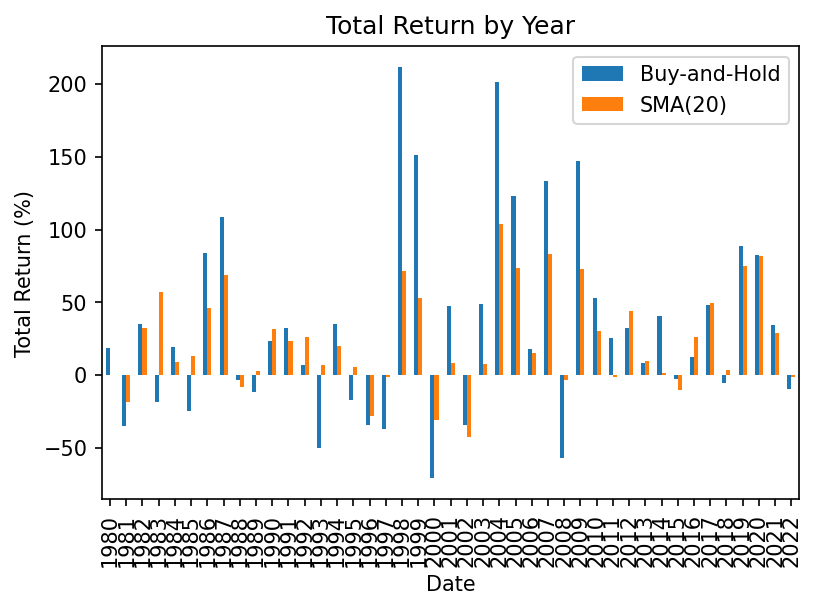

In [19]:
_ = pd.DataFrame(data={'R_AAPL': list_aapl, 'R_Strategy': list_strategy}, index=range(1980, 2023))
_.mul(100).plot(kind='bar')
plt.ylabel('Total Return (%)')
plt.xlabel('Date')
plt.legend(['Buy-and-Hold', 'SMA(20)'])
plt.title('Total Return by Year')
plt.show()

We can do this plot more easily with pandas methods!
We will learn more details about `.resample()` in a few weeks!

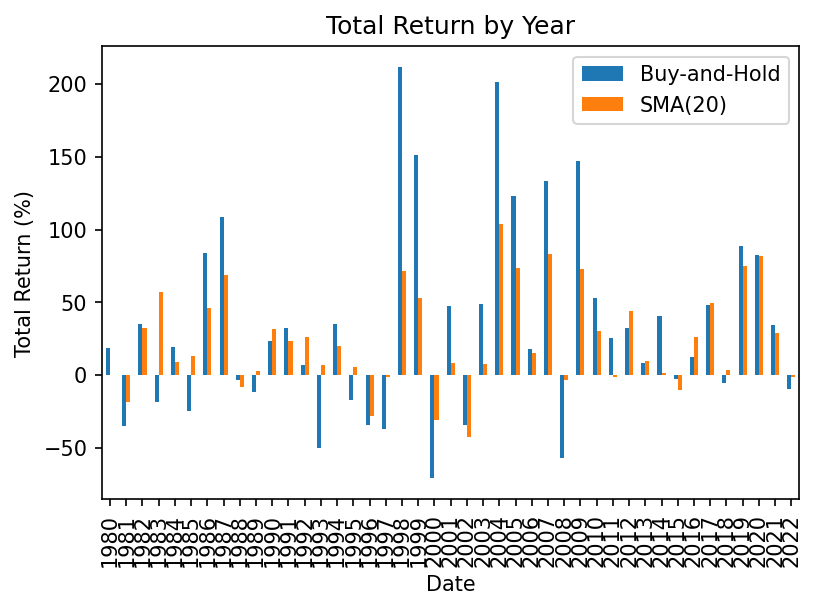

In [20]:
aapl[['R_AAPL', 'R_Strategy']].resample('A', kind='period').apply(totret).mul(100).plot(kind='bar')
plt.ylabel('Total Return (%)')
plt.legend(['Buy-and-Hold', 'SMA(20)'])
plt.title('Total Return by Year')
plt.show()

***Practice:***
What are the full-sample Sharpe Ratios of these two stategies?
***FOR NOW, ASSUME THE RISK-FREE RATE IS ALWAYS 0%, so $R_F = 0$.***
$$SR = \frac{\overline{R - R_F}}{\sigma}$$

The mean of returns grows linearly with time, so we annualize the mean of daily returns by multiplying by 252 because there are about 252 trading days per year.
The standard deviations of returns grows with the *square root* of time, so we annualize the standard deviation of daily returns by multiplying by $\sqrt{252}$.

In [21]:
(252 * aapl[['R_AAPL', 'R_Strategy']].mean()) / (np.sqrt(252) * aapl[['R_AAPL', 'R_Strategy']].std())

R_AAPL       0.6227
R_Strategy   0.7623
dtype: float64

Here $\frac{252}{\sqrt{252}} = \sqrt{252}$, so we can simplify our math.

In [22]:
np.sqrt(252) * aapl[['R_AAPL', 'R_Strategy']].mean() / aapl[['R_AAPL', 'R_Strategy']].std()

R_AAPL       0.6227
R_Strategy   0.7623
dtype: float64

Here is a crude simulation to show that means of returns grow linearly with time but standard deviations of returns grow with the standard deviation of time.
If we have quarterly returns, we can find the annual return by compounding the quarterly returns.
That is, $$r_a = (1+r_{q1})\cdot(1+r_{q2})\cdot(1+r_{q3})\cdot(1+r_{q4}) - 1$$

In [23]:
np.random.seed(42)
rq1 = np.random.normal(loc=0.01, scale=0.01, size=1000000)
rq2 = np.random.normal(loc=0.01, scale=0.01, size=1000000)
rq3 = np.random.normal(loc=0.01, scale=0.01, size=1000000)
rq4 = np.random.normal(loc=0.01, scale=0.01, size=1000000)

In [24]:
ra = (1 + rq1)*(1 + rq2)*(1 + rq3)*(1 + rq4) - 1

Here the mean quarterly return is 0.01, and there are 4 quarters per year, so the mean annual return is $4 \cdot 0.01 = 0.04$.

In [25]:
ra.mean()

0.040593559355657616

Likewise, the standard deviation of quarterly returns is 0.01, so the standard deviation of annual returns is $\sqrt{4} \cdot 0.01 = 2 \cdot 0.01 = 0.02$.

In [26]:
ra.std()

0.020626264802184036

This relation is not perfect in real data, but we still annualize daily means with 252 and daily standard deviations with $\sqrt{252}$.
Likewise, we still annualize monthly means with 12 and daily standard deviations with $\sqrt{12}$.

In [27]:
aapl.loc['1981':'2021', ['R_AAPL', 'R_Strategy']].resample('A', kind='period').apply(totret).mean()

R_AAPL       0.3539
R_Strategy   0.2529
dtype: float64

In [28]:
aapl.loc['1981':'2021', ['R_AAPL', 'R_Strategy']].mean() * 252

R_AAPL       0.2813
R_Strategy   0.2316
dtype: float64

In [29]:
aapl.loc['1981':'2021', ['R_AAPL', 'R_Strategy']].resample('A', kind='period').apply(totret).std()

R_AAPL       0.6740
R_Strategy   0.3459
dtype: float64

In [30]:
aapl.loc['1981':'2021', ['R_AAPL', 'R_Strategy']].std() * np.sqrt(252)

R_AAPL       0.4504
R_Strategy   0.3006
dtype: float64

---

# Calculating Bollinger Bands and testing a buy/sell strategy

John Bollinger developed Bollinger Bands in the early 1980s.
He describes Bollinger Bands as follows:

> So what are Bollinger Bands? They are curves drawn in and around the price structure usually consisting of a moving average (the middle band), an upper band, and a lower band that answer the question as to whether prices are high or low on a relative basis. Bollinger Bands work best when the middle band is chosen to reflect the intermediate-term trend, so that trend information is combined with relative price level data.

More [here](https://www.bollingerbands.com/bollinger-bands).
John Bollinger provides a list of rules [here](https://www.bollingerbands.com/bollinger-band-rules).
In short, Bollinger Bands are bands around a trend (typically $\mu_{price} \pm 2\sigma_{price}$ using 20 trading days).
Technical analysts use these bands to signal high and low prices.

Lewinson builds Bollinger Bands with the backtrader package, but we will build Bollinger Bands with pandas.
Lewinson desribes Bollinger Bands as follows:

> Bollinger Bands are a statistical method, used for deriving information about the prices and volatility of a certain asset over time. To obtain the Bollinger Bands, we need to calculate the moving average and standard deviation of the time series (prices), using a specified window (typically, 20 days). Then, we set the upper/lower bands at K times (typically, 2) the moving standard deviation above/below the moving average.
>
> The interpretation of the bands is quite sample: the bands widen with an increase in volatility and contract with a decrease in volatility.
> 
> In this recipe, we build a simple trading strategy, with the following rules:
>
>    - Buy when the price crosses the lower Bollinger Band upwards.
>    - Sell (only if stocks are in possession) when the price crosses the upper Bollinger Band downward.
>    - All-in strategy—when creating a buy order, buy as many shares as possible.
>    - Short selling is not allowed.

We will implement Lewinson's strategy with Tesla.

First, we will plot the 20-day rolling means and plus/minus 2 standard deviations.

In [31]:
tsla = yf.download('TSLA', session=session)

[*********************100%***********************]  1 of 1 completed


In [32]:
tsla['R_TSLA'] = tsla['Adj Close'].pct_change()

In [33]:
win = 20
K = 2

tsla[['SMA20', 'SMV20']] = tsla['Adj Close'].rolling(win).agg(['mean', 'std'])

tsla['LB'] = tsla['SMA20'] - K*tsla['SMV20']
tsla['UB'] = tsla['SMA20'] + K*tsla['SMV20']

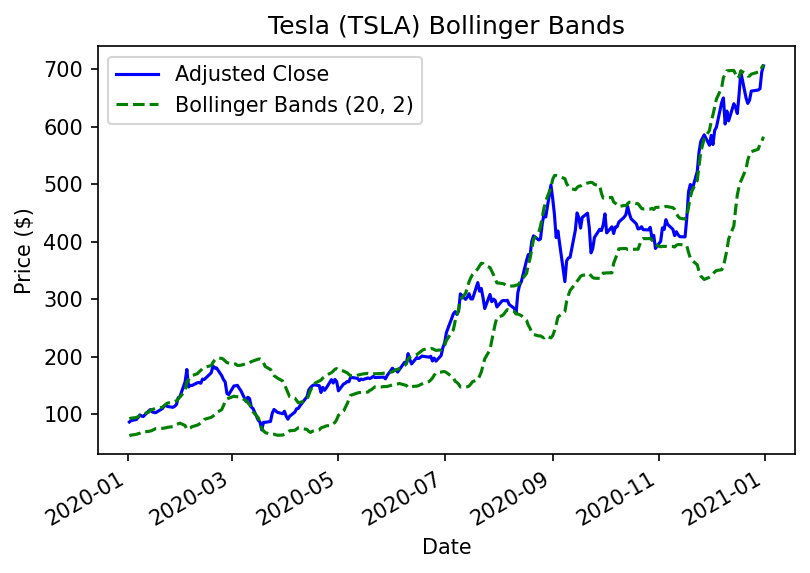

In [34]:
_ = tsla.loc['2020', ['Adj Close', 'LB', 'UB']]
_.plot(style=['b-', 'g--', 'g--'])
plt.legend(['Adjusted Close', 'Bollinger Bands ({}, {})'.format(win, K)])
plt.ylabel('Price ($)')
plt.title('Tesla (TSLA) Bollinger Bands')
plt.show()

---

***Practice:***
Implement this strategy (i.e., create the position and return columns for this strategy).

In [35]:
tsla['Position'] = np.select(
    condlist=[
        (tsla['Adj Close'].shift(1) > tsla['LB'].shift(1)) & (tsla['Adj Close'].shift(2) < tsla['LB'].shift(2)),
        (tsla['Adj Close'].shift(1) < tsla['UB'].shift(1)) & (tsla['Adj Close'].shift(2) > tsla['UB'].shift(2))
    ], 
    choicelist=[1, 0],
    default=np.nan
)

We can quickly find the trades with `tsla.dropna()`, then select a date range to examine closely.

In [36]:
tsla.dropna()

,Open,High,Low,Close,Adj Close,Volume,R_TSLA,SMA20,SMV20,LB,UB,Position
Date,,,,,,,,,,,,
2010-08-16,3.6900,3.7600,3.6520,3.7560,3.7560,2429000,0.0251,4.0072,0.2376,3.5320,4.4824,1.0000
2010-09-07,4.1220,4.2000,4.1000,4.1080,4.1080,1217000,-0.0242,3.8857,0.1904,3.5048,4.2666,0.0000
2010-09-17,4.2040,4.2640,3.9600,4.0460,4.0460,5992500,-0.0339,4.0700,0.1462,3.7775,4.3625,0.0000
2010-11-02,4.3360,4.3760,4.2100,4.2500,4.2500,1612500,-0.0075,4.1493,0.0938,3.9617,4.3369,0.0000
2010-11-10,4.8960,5.9940,4.8100,5.8720,5.8720,15302500,0.1920,4.4267,0.4679,3.4908,5.3626,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,902.2500,934.4000,870.0000,870.7600,870.7600,29377700,-0.0077,997.3875,74.8530,847.6815,1147.0935,1.0000
2022-05-11,795.0000,809.7700,727.2000,734.0000,734.0000,32408200,-0.0825,917.9975,85.4598,747.0779,1088.9171,1.0000
2022-05-13,773.4800,787.3500,751.5700,769.5900,769.5900,30716900,0.0571,892.5085,94.1754,704.1576,1080.8594,1.0000


In [37]:
tsla.loc['2010-08-10':'2010-08-20']

,Open,High,Low,Close,Adj Close,Volume,R_TSLA,SMA20,SMV20,LB,UB,Position
Date,,,,,,,,,,,,
2010-08-10,3.9300,3.9300,3.7640,3.8060,3.8060,6406500,-0.0291,4.1040,0.1525,3.7990,4.4090,NaN
2010-08-11,3.7380,3.7760,3.5700,3.5800,3.5800,3988000,-0.0594,4.0846,0.1906,3.7033,4.4659,NaN
2010-08-12,3.5600,3.5800,3.4780,3.5200,3.5200,3455000,-0.0168,4.0617,0.2280,3.6058,4.5176,NaN
2010-08-13,3.6360,3.6900,3.5320,3.6640,3.6640,3170000,0.0409,4.0385,0.2439,3.5507,4.5263,NaN
2010-08-16,3.6900,3.7600,3.6520,3.7560,3.7560,2429000,0.0251,4.0072,0.2376,3.5320,4.4824,1.0000
2010-08-17,3.7920,3.8800,3.7560,3.8300,3.8300,2239500,0.0197,3.9957,0.2405,3.5148,4.4766,NaN
2010-08-18,3.9180,3.9180,3.7200,3.7540,3.7540,3006500,-0.0198,3.9812,0.2461,3.4891,4.4733,NaN
2010-08-19,3.7080,3.8500,3.6660,3.7580,3.7580,2895500,0.0011,3.9591,0.2452,3.4686,4.4496,NaN
2010-08-20,3.7300,3.8220,3.7020,3.8200,3.8200,1480000,0.0165,3.9372,0.2365,3.4641,4.4103,NaN


First, carry forward each position.

In [38]:
tsla['Position'].fillna(method='ffill', inplace=True)

In [39]:
tsla.loc['2010-08-10':'2010-08-20']

,Open,High,Low,Close,Adj Close,Volume,R_TSLA,SMA20,SMV20,LB,UB,Position
Date,,,,,,,,,,,,
2010-08-10,3.9300,3.9300,3.7640,3.8060,3.8060,6406500,-0.0291,4.1040,0.1525,3.7990,4.4090,NaN
2010-08-11,3.7380,3.7760,3.5700,3.5800,3.5800,3988000,-0.0594,4.0846,0.1906,3.7033,4.4659,NaN
2010-08-12,3.5600,3.5800,3.4780,3.5200,3.5200,3455000,-0.0168,4.0617,0.2280,3.6058,4.5176,NaN
2010-08-13,3.6360,3.6900,3.5320,3.6640,3.6640,3170000,0.0409,4.0385,0.2439,3.5507,4.5263,NaN
2010-08-16,3.6900,3.7600,3.6520,3.7560,3.7560,2429000,0.0251,4.0072,0.2376,3.5320,4.4824,1.0000
2010-08-17,3.7920,3.8800,3.7560,3.8300,3.8300,2239500,0.0197,3.9957,0.2405,3.5148,4.4766,1.0000
2010-08-18,3.9180,3.9180,3.7200,3.7540,3.7540,3006500,-0.0198,3.9812,0.2461,3.4891,4.4733,1.0000
2010-08-19,3.7080,3.8500,3.6660,3.7580,3.7580,2895500,0.0011,3.9591,0.2452,3.4686,4.4496,1.0000
2010-08-20,3.7300,3.8220,3.7020,3.8200,3.8200,1480000,0.0165,3.9372,0.2365,3.4641,4.4103,1.0000


Then intialize our strategy with a neutral position.

In [40]:
tsla['Position'].fillna(value=0, inplace=True)

In [41]:
tsla

,Open,High,Low,Close,Adj Close,Volume,R_TSLA,SMA20,SMV20,LB,UB,Position
Date,,,,,,,,,,,,
2010-06-29,3.8000,5.0000,3.5080,4.7780,4.7780,93831500,NaN,NaN,NaN,NaN,NaN,0.0000
2010-06-30,5.1580,6.0840,4.6600,4.7660,4.7660,85935500,-0.0025,NaN,NaN,NaN,NaN,0.0000
2010-07-01,5.0000,5.1840,4.0540,4.3920,4.3920,41094000,-0.0785,NaN,NaN,NaN,NaN,0.0000
2010-07-02,4.6000,4.6200,3.7420,3.8400,3.8400,25699000,-0.1257,NaN,NaN,NaN,NaN,0.0000
2010-07-06,4.0000,4.0000,3.1660,3.2220,3.2220,34334500,-0.1609,NaN,NaN,NaN,NaN,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-27,791.4300,827.7800,785.3700,824.4600,824.4600,29370000,0.0617,735.4210,47.9828,639.4554,831.3866,0.0000
2022-07-28,840.2000,849.9000,818.4000,842.7000,842.7000,28241000,0.0221,743.2825,52.0740,639.1346,847.4304,0.0000
2022-07-29,842.1000,894.9600,837.3000,891.4500,891.4500,31771000,0.0578,754.1840,59.0353,636.1133,872.2547,0.0000


Then create the return series for our strategy.

In [42]:
tsla.eval('R_Strategy = R_TSLA * Position', inplace=True)

***Practice:***
Compare the performance of the Bollinger Band strategy to buy-and-hold TSLA (e.g., total returns and Sharpe Ratios).

In [43]:
tsla[['R_TSLA', 'R_Strategy']].apply(totret) * 100

R_TSLA       18773.1694
R_Strategy     813.4838
dtype: float64

In [44]:
np.sqrt(252) * tsla[['R_TSLA', 'R_Strategy']].mean() / tsla[['R_TSLA', 'R_Strategy']].std()

R_TSLA       1.0453
R_Strategy   0.6833
dtype: float64

---

# Calculating the relative strength index and testing a long/short strategy

Lewinson describes the relative strength index (RSI) as follows:

> The RSI is an indicator that uses the closing prices of an asset to identify oversold/overbought conditions. Most commonly, the RSI is calculated using a 14-day period, and it is measured on a scale from 0 to 100 (it is an oscillator). Traders usually buy an asset when it is oversold (if the RSI is below 30), and sell when it is overbought (if the RSI is above 70). More extreme high/low levels, such as 80-20, are used less frequently and, at the same time, imply stronger momentum.
> 
> In this recipe, we build a trading strategy with the following rules:
>
>    - We can go long and short.
>    - For calculating the RSI, we use 14 periods (trading days).
>    - Enter a long position if the RSI crosses the lower threshold (standard value of 30) upwards; exit the position when the RSI becomes larger than the middle level (value of 50).
>    - Enter a short position if the RSI crosses the upper threshold (standard value of 70) downwards; exit the position when the RSI becomes smaller than 50.
>    - Only one position can be open at a time.

Lewinson uses a package to calculate the RSI and implement his strategy above.
We do not need a package!
Here is RSI's formula: $$RSI = 100 - \frac{100}{1 + RS},$$ where $$RS = \frac{SMA(U, n)}{SMA(D, n)}.$$
For "up days", $U = \Delta Adj\ Close$ and $D = 0$.
For "down days", $U = 0$ and $D = - \Delta Adj\ Close$, so that $U$ and $D$ are always non-negative.
We can learn more about RSI [here](https://en.wikipedia.org/wiki/Relative_strength_index).

We will use Tesla data, again, for this section, but in a new data frame `tsla2`.

In [45]:
tsla2 = yf.download('TSLA', session=session)

[*********************100%***********************]  1 of 1 completed


In [46]:
tsla2['R_TSLA'] = tsla2['Adj Close'].pct_change()

---

***Practice:***
Write a function `rsi()` that calculates $RSI$ for a return series with default $n = 14$.
For this version of `rsi()`, make the input the change in the adjusted close.
In other words, we will call `rsi()` as `rsi(tsla2['Adj Close'].diff())`.

In [47]:
def rsi(x, n=14):
    U = np.maximum(x, 0)
    D = -1 * np.minimum(x, 0)
    SMAU = U.rolling(n).mean()
    SMAD = D.rolling(n).mean()
    RS = SMAU / SMAD
    return 100 - 100 / (1 + RS)

***Practice:***
Implement Lewinson's strategy for Tesla.

In [48]:
win2 = 14
lb2 = 30
mb2 = 50
ub2 = 70

In [49]:
tsla2['RSI'] = rsi(tsla2['Adj Close'].diff(), n=win2)

We expect $RSI$ to

In [50]:
tsla2['RSI'].describe()

count   3031.0000
mean      53.8625
std       17.3606
min        5.1392
25%       41.1189
50%       53.6987
75%       66.8737
max       97.1292
Name: RSI, dtype: float64

In [51]:
tsla2['Position'] = np.select(
    condlist=[
        (tsla2['RSI'].shift(1) > lb2) & (tsla2['RSI'].shift(2) <= lb2),
        (tsla2['RSI'].shift(1) > mb2) & (tsla2['RSI'].shift(2) <= mb2),
        (tsla2['RSI'].shift(1) < ub2) & (tsla2['RSI'].shift(2) >= ub2),
        (tsla2['RSI'].shift(1) < mb2) & (tsla2['RSI'].shift(2) >= mb2)
    ], 
    choicelist=[1, 0, -1, 0],
    default=np.nan
)

In [52]:
tsla2['Position'].fillna(method='ffill', inplace=True)

In [53]:
tsla2['Position'].fillna(value=0, inplace=True)

In [54]:
tsla2.eval('R_Strategy = Position * R_TSLA', inplace=True)

Text(0.5, 0.98, 'Relative Strength Index (RSI) Strategy for Tesla (TSLA)')

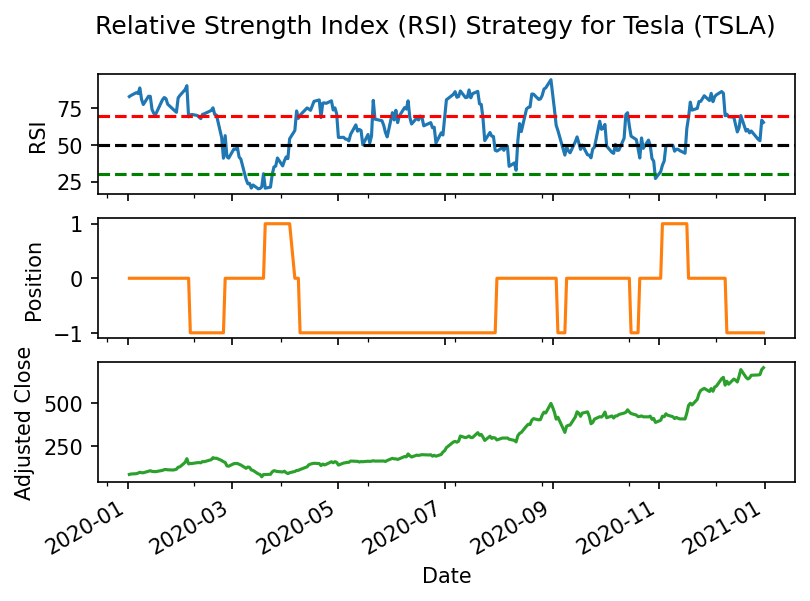

In [55]:
axes = tsla2.loc['2020', ['RSI', 'Position', 'Adj Close']].plot(subplots=True, legend=False)
axes[0].set_ylabel('RSI')
axes[0].axhline(lb2, **{'color':'g', 'linestyle':'--'})
axes[0].axhline(mb2, **{'color':'k', 'linestyle':'--'})
axes[0].axhline(ub2, **{'color':'r', 'linestyle':'--'})
axes[1].set_ylabel('Position')
axes[2].set_ylabel('Adjusted Close')
plt.suptitle('Relative Strength Index (RSI) Strategy for Tesla (TSLA)')

***Practice:***
Compare the performance of the RSI strategy to buy-and-hold TSLA (e.g., total returns and Sharpe Ratios).

In [56]:
tsla2[['R_TSLA', 'R_Strategy']].apply(totret) * 100

R_TSLA       18773.1694
R_Strategy     -93.0535
dtype: float64

In [57]:
np.sqrt(252) * tsla2[['R_TSLA', 'R_Strategy']].mean() / tsla2[['R_TSLA', 'R_Strategy']].std()

R_TSLA        1.0453
R_Strategy   -0.4091
dtype: float64

Once we calculate a statistic more than a few times, we should write a function.
***AGAIN, HERE WE USE $R_F = 0\%$ FOR SIMPLICITY. AFTER WE LEARN TO MERGE DATA, WE WILL USE THE TRUE RISK-FREE RATE TO CALCULATE SHARPE RATIOS.***

In [58]:
def sr(r, rpy=252): # here rpy is "returns per year" to annualize Sharpe Ratio
    return np.sqrt(rpy) * r.mean() / r.std()

In [59]:
tsla2[['R_TSLA', 'R_Strategy']].apply(sr)

R_TSLA        1.0453
R_Strategy   -0.4091
dtype: float64

---